In [1]:

from geodude.utils import Paper, merge_LineStrings
import vsketch
import numpy as np
from shapely.geometry import (
    box, 
    MultiLineString, 
    Point, 
    MultiPoint, 
    Polygon, 
    MultiPolygon, 
    LineString,
    )
%load_ext autoreload
%autoreload 2
from fn.fn import new_savepath
from geodude.ops import make_like
from shapely import is_valid, unary_union
import itertools
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from geodude.line import dash_linestring
from geodude.intersection import (
    pairwise_partition_polygons, 
    polys_to_gdf, 
    find_intersecting_polys,
    find_touching_polys, 
    find_clusters, 
    find_contained_polys, 
    find_parent_polygons,
    merge_disjoint_polys,
    assign_random_order_to_adjacent_clusters,
    assign_psuedoperiodic_order_to_adjacent_clusters,
    chunked_pairwise_partition_polygons
    )
from geodude.ops import multi_buffer_translate, MultiBufferTranslatePrms
# make page
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

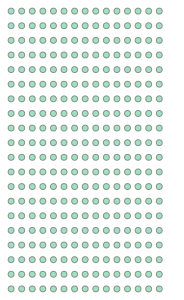

In [2]:
n_xs = 15
n_ys = 20
n_pts = n_xs * n_ys
xs = np.linspace(30, 190, n_xs)
ys = np.linspace(0, 300, n_ys)
pts = [Point(x, y) for x, y in itertools.product(xs, ys)]
radii = [np.interp(pt.y, [0, 150, 300], [1, 20, 1]) for pt in pts]
thicknesses = [np.interp(pt.y, [0, 150, 300], [0.3, 2.2, 0.3]) for pt in pts]

MultiPoint(pts)

In [3]:
circles = [p.buffer(r).boundary.buffer(thickness) for p,r, thickness in zip(pts, radii, thicknesses)]

In [4]:
gdf = polys_to_gdf(circles)
disjoint = chunked_pairwise_partition_polygons(
    gdf, 
    chunk_size=10,
    min_area=1e-3,
    )

Iteration 1
Finding intersections in 300 polygons
2770 intersections remaining
Chunking polygons
Partitioning 21 chunks


21it [00:06,  3.17it/s]


Iteration 1 complete, 2099 polygons remaining
Iteration 2
Finding intersections in 2099 polygons
6588 intersections remaining
Chunking polygons
Partitioning 128 chunks


128it [00:07, 16.24it/s]


Iteration 2 complete, 2746 polygons remaining
Iteration 3
Finding intersections in 2746 polygons
7042 intersections remaining
Chunking polygons
Partitioning 192 chunks


192it [00:11, 17.45it/s]


Iteration 3 complete, 3699 polygons remaining
Iteration 4
Finding intersections in 3699 polygons
5950 intersections remaining
Chunking polygons
Partitioning 214 chunks


214it [00:10, 19.86it/s]


Iteration 4 complete, 3531 polygons remaining
Iteration 5
Finding intersections in 3531 polygons
4030 intersections remaining
Chunking polygons
Partitioning 183 chunks


183it [00:07, 23.54it/s]


Iteration 5 complete, 2663 polygons remaining
Iteration 6
Finding intersections in 2663 polygons
2378 intersections remaining
Chunking polygons
Partitioning 126 chunks


126it [00:05, 24.39it/s]


Iteration 6 complete, 1660 polygons remaining
Iteration 7
Finding intersections in 1660 polygons
1236 intersections remaining
Chunking polygons
Partitioning 71 chunks


71it [00:02, 31.07it/s]


Iteration 7 complete, 841 polygons remaining
Iteration 8
Finding intersections in 841 polygons
726 intersections remaining
Chunking polygons
Partitioning 42 chunks


42it [00:01, 28.30it/s]


Iteration 8 complete, 515 polygons remaining
Iteration 9
Finding intersections in 515 polygons
418 intersections remaining
Chunking polygons
Partitioning 24 chunks


24it [00:00, 37.36it/s]


Iteration 9 complete, 266 polygons remaining
Iteration 10
Finding intersections in 266 polygons
294 intersections remaining
Chunking polygons
Partitioning 17 chunks


17it [00:00, 40.89it/s]


Iteration 10 complete, 189 polygons remaining
Iteration 11
Finding intersections in 189 polygons
220 intersections remaining
Chunking polygons
Partitioning 13 chunks


13it [00:00, 27.04it/s]


Iteration 11 complete, 160 polygons remaining
Iteration 12
Finding intersections in 160 polygons
120 intersections remaining
Chunking polygons
Partitioning 8 chunks


8it [00:00, 29.61it/s]


Iteration 12 complete, 94 polygons remaining
Iteration 13
Finding intersections in 94 polygons
60 intersections remaining
Chunking polygons
Partitioning 5 chunks


5it [00:00, 28.56it/s]


Iteration 13 complete, 47 polygons remaining
Iteration 14
Finding intersections in 47 polygons
18 intersections remaining
Chunking polygons
Partitioning 2 chunks


2it [00:00, 33.57it/s]


Iteration 14 complete, 13 polygons remaining
Iteration 15
Finding intersections in 13 polygons
4 intersections remaining
Chunking polygons
Partitioning 1 chunks


1it [00:00, 45.64it/s]

Iteration 15 complete, 3 polygons remaining
Iteration 16
Finding intersections in 3 polygons
0 intersections remaining
Chunking polygons


In [9]:

disjoint = find_parent_polygons(disjoint=disjoint, original=gdf)

disjoint = assign_random_order_to_adjacent_clusters(disjoint)


<Axes: >

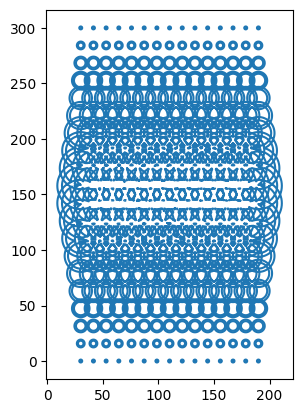

In [44]:
disjoint.query('n_parents == 1').boundary.plot()

In [29]:

ngdf = merge_disjoint_polys(disjoint)


# clean up with closing + opening
buffer_value = 0.01
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
# ngdf = ngdf.explode(index_parts=False)


<Axes: >

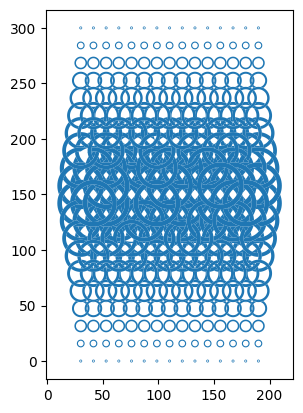

In [31]:
ngdf.plot()

<Axes: >

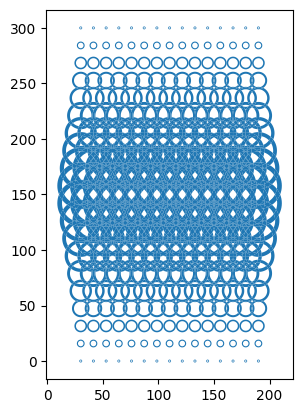

In [8]:
disjoint.plot()

In [6]:

ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-6) & ~ngdf.is_empty & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf = ngdf[idx]

lss = [p.boundary for p in ngdf.geometry if p.boundary is not None]
mls = merge_LineStrings(lss)



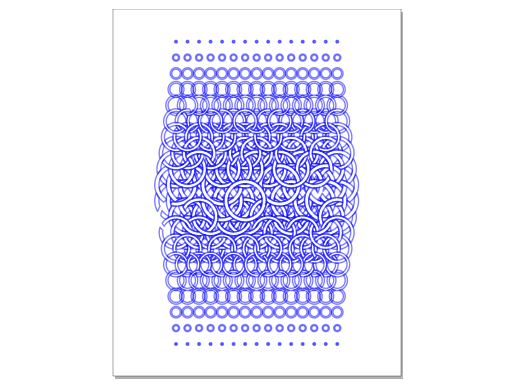

In [7]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(mls, drawbox))
sk.display()


In [13]:
middle_circle = Point(110, 150).buffer(50)
middle_lines = mls.intersection(middle_circle)
outer_lines = mls.difference(middle_circle)

In [25]:
breakpoint_sets = []
for ii in range(len(middle_lines.geoms)):
    breakpoint_set = np.random.uniform(0, 1, 1)
    second_breakpoints = breakpoint_set.copy() + np.random.uniform(0, 0.2, len(breakpoint_set))
    breakpoint_set = np.concatenate([breakpoint_set, second_breakpoints])
    breakpoint_sets.append(np.sort(breakpoint_set))
    
dashed_lines = [dash_linestring(ls, breakpoints) for ls, breakpoints in zip(middle_lines.geoms, breakpoint_sets)]
dashed_lines = merge_LineStrings(dashed_lines)

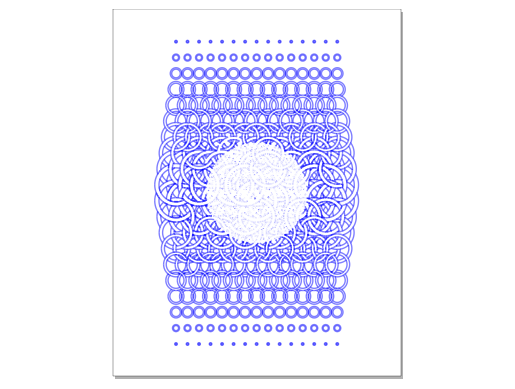

In [26]:

dashed_mls = merge_LineStrings([dashed_lines, outer_lines])
dashed_mls = make_like(dashed_mls, drawbox)
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)

sk.geometry(dashed_mls)
sk.display()

In [27]:
sk.vpype('splitall linemerge linesort')

In [28]:
fp = new_savepath(postfix='gap_in_the_tangle')
sk.save(fp)

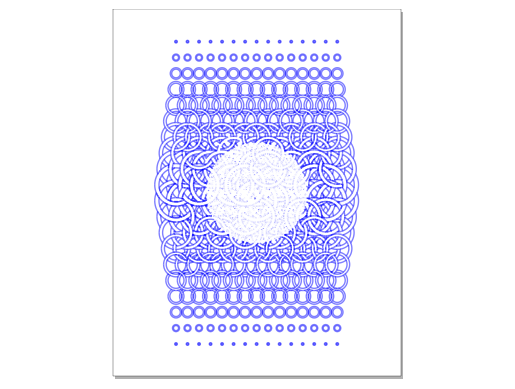

In [ ]:

dashed_mls = merge_LineStrings([dashed_lines, outer_lines])
dashed_mls = make_like(dashed_mls, drawbox)
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)

sk.geometry(dashed_mls)
sk.display()

In [ ]:
sk.vpype('splitall linemerge linesort')
fp = new_savepath(postfix='gap_in_the_tangle')
sk.save(fp)

# fills

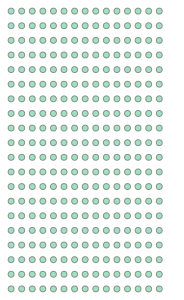

In [158]:
n_xs = 15
n_ys = 20
n_pts = n_xs * n_ys
xs = np.linspace(30, 190, n_xs)
ys = np.linspace(0, 300, n_ys)
pts = [Point(x, y) for x, y in itertools.product(xs, ys)]
radii = [np.interp(pt.y, [0, 150, 300], [1, 20, 1]) for pt in pts]
thicknesses = [np.interp(pt.y, [0, 150, 300], [0.3, 2.3, 0.3]) for pt in pts]

MultiPoint(pts)

In [159]:
circles = [p.buffer(r).boundary.buffer(thickness) for p,r, thickness in zip(pts, radii, thicknesses)]

In [160]:
gdf = polys_to_gdf(circles)
disjoint = chunked_pairwise_partition_polygons(
    gdf, 
    chunk_size=10,
    min_area=1e-3,
    )

Iteration 1
Finding intersections in 300 polygons
2826 intersections remaining
Chunking polygons
Partitioning 24 chunks


24it [00:05,  4.55it/s]


Iteration 1 complete, 1784 polygons remaining
Iteration 2
Finding intersections in 1784 polygons
6306 intersections remaining
Chunking polygons
Partitioning 116 chunks


116it [00:07, 15.10it/s]


Iteration 2 complete, 2652 polygons remaining
Iteration 3
Finding intersections in 2652 polygons
6984 intersections remaining
Chunking polygons
Partitioning 178 chunks


178it [00:11, 16.05it/s]


Iteration 3 complete, 3546 polygons remaining
Iteration 4
Finding intersections in 3546 polygons
6154 intersections remaining
Chunking polygons
Partitioning 204 chunks


204it [00:10, 19.40it/s]


Iteration 4 complete, 3462 polygons remaining
Iteration 5
Finding intersections in 3462 polygons
4604 intersections remaining
Chunking polygons
Partitioning 191 chunks


191it [00:09, 20.78it/s]


Iteration 5 complete, 2920 polygons remaining
Iteration 6
Finding intersections in 2920 polygons
2862 intersections remaining
Chunking polygons
Partitioning 138 chunks


138it [00:05, 23.29it/s]


Iteration 6 complete, 1903 polygons remaining
Iteration 7
Finding intersections in 1903 polygons
1638 intersections remaining
Chunking polygons
Partitioning 89 chunks


89it [00:03, 25.38it/s]


Iteration 7 complete, 1142 polygons remaining
Iteration 8
Finding intersections in 1142 polygons
878 intersections remaining
Chunking polygons
Partitioning 52 chunks


52it [00:02, 25.89it/s]


Iteration 8 complete, 643 polygons remaining
Iteration 9
Finding intersections in 643 polygons
434 intersections remaining
Chunking polygons
Partitioning 28 chunks


28it [00:00, 28.98it/s]


Iteration 9 complete, 320 polygons remaining
Iteration 10
Finding intersections in 320 polygons
212 intersections remaining
Chunking polygons
Partitioning 13 chunks


13it [00:00, 31.72it/s]


Iteration 10 complete, 152 polygons remaining
Iteration 11
Finding intersections in 152 polygons
128 intersections remaining
Chunking polygons
Partitioning 8 chunks


8it [00:00, 26.06it/s]


Iteration 11 complete, 92 polygons remaining
Iteration 12
Finding intersections in 92 polygons
66 intersections remaining
Chunking polygons
Partitioning 5 chunks


5it [00:00, 22.10it/s]


Iteration 12 complete, 60 polygons remaining
Iteration 13
Finding intersections in 60 polygons
16 intersections remaining
Chunking polygons
Partitioning 2 chunks


2it [00:00, 25.69it/s]


Iteration 13 complete, 15 polygons remaining
Iteration 14
Finding intersections in 15 polygons
0 intersections remaining
Chunking polygons


In [161]:

disjoint = find_parent_polygons(disjoint=disjoint, original=gdf)


In [162]:

disjoint = assign_random_order_to_adjacent_clusters(disjoint)


In [163]:

ngdf = merge_disjoint_polys(disjoint)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)


In [120]:
from shapely import make_valid

In [164]:

ogngdf = ngdf.copy()

# clean up with closing
buffer_value = 1e-12
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
# ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)

ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

In [122]:
# ngdf.geometry = make_valid(ngdf.geometry)

<Axes: >

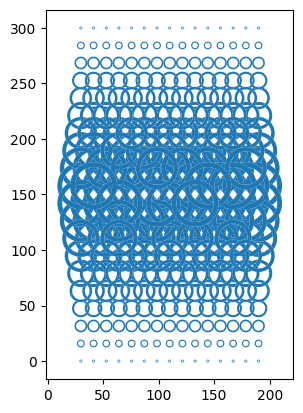

In [165]:
ngdf.plot()

<Axes: >

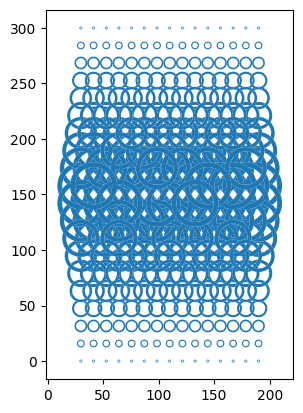

In [166]:

ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-6)
idx = idx & ~ngdf.is_empty
idx = idx & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf[idx].plot()

In [198]:

ngdf = ngdf[idx]

lss = [p.boundary for p in ngdf.geometry if p.boundary is not None]
mls = merge_LineStrings(lss)



/Users/alexandernaka/Library/Caches/pypoetry/virtualenvs/dashing-J-UKP8fp-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


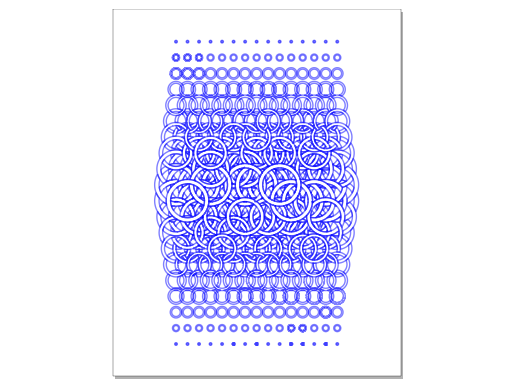

In [199]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(mls, drawbox))
sk.display()


In [200]:
middle_circle = Point(110, 150).buffer(70)
middle_lines = mls.intersection(middle_circle)
outer_polys = ngdf.difference(middle_circle)

In [201]:
disjoint_copy = disjoint.copy()
disjoint_copy.geometry = disjoint_copy.geometry.difference(middle_circle)
disjoint_copy = disjoint_copy[~disjoint_copy.geometry.is_empty]

<Axes: >

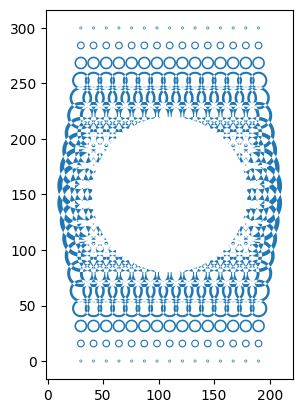

In [202]:
parents = [1, ]
disjoint_copy.query('n_parents in @parents').plot()

In [203]:

parents = [1,]

fills = []
for p in disjoint_copy.query('n_parents in @parents').geometry:
    prms = MultiBufferTranslatePrms(
        d_buffer = -0.25, 
        d_translate_factor = 0.9, 
        angles=np.interp(p.centroid.x, [0, 210], [0, np.pi]),
        ).prms
    polys = multi_buffer_translate(p, **prms)
    fill = [p.boundary for p in polys]
    fills.extend(fill)


In [204]:
fills = [f for f in fills if f is not None]

In [205]:
mls = merge_LineStrings(fills + [middle_lines])

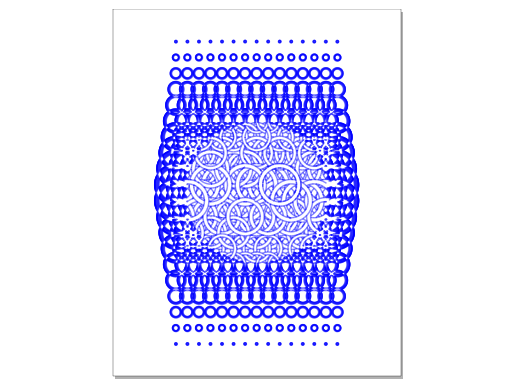

In [206]:

final_mls = make_like(mls, drawbox)
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)

sk.geometry(final_mls)
sk.display()

In [207]:
sk.vpype('splitall linemerge linesort')
fp = new_savepath(postfix='negative_space_intersections')
sk.save(fp)

# more

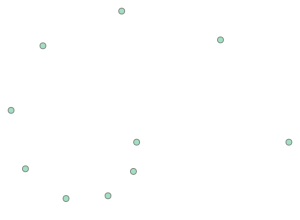

In [280]:
n_pts =10
angles = np.linspace(0, 360*8, n_pts)
rs = np.logspace(np.log10(40), np.log10(200), n_pts)
radii =  np.logspace(np.log10(165), np.log10(280), n_pts)
thicknesses = np.logspace(np.log10(4), np.log10(30), n_pts)
pts = [Point(r*np.cos(np.deg2rad(a)), r*np.sin(np.deg2rad(a))) for a, r in zip(angles, rs)]
MultiPoint(pts)

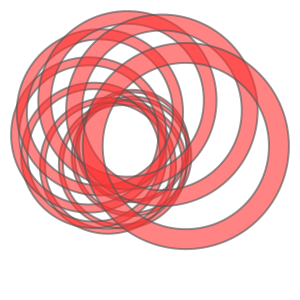

In [351]:
circles = [p.buffer(r, resolution=128).boundary.buffer(thickness) for p,r, thickness in zip(pts, radii, thicknesses)]
mp = MultiPolygon(circles)
mp


In [352]:
gdf = polys_to_gdf(circles)
disjoint = chunked_pairwise_partition_polygons(
    gdf, 
    chunk_size=10,
    min_area=1e-3,
    )

Iteration 1
Finding intersections in 10 polygons
90 intersections remaining
Chunking polygons
Partitioning 1 chunks


1it [00:00, 16.33it/s]


Iteration 1 complete, 30 polygons remaining
Iteration 2
Finding intersections in 30 polygons
194 intersections remaining
Chunking polygons
Partitioning 3 chunks


3it [00:00, 35.67it/s]


Iteration 2 complete, 57 polygons remaining
Iteration 3
Finding intersections in 57 polygons
194 intersections remaining
Chunking polygons
Partitioning 5 chunks


5it [00:00, 12.00it/s]


Iteration 3 complete, 148 polygons remaining
Iteration 4
Finding intersections in 148 polygons
144 intersections remaining
Chunking polygons
Partitioning 7 chunks


7it [00:00, 15.73it/s]


Iteration 4 complete, 135 polygons remaining
Iteration 5
Finding intersections in 135 polygons
76 intersections remaining
Chunking polygons
Partitioning 5 chunks


5it [00:00, 19.61it/s]


Iteration 5 complete, 93 polygons remaining
Iteration 6
Finding intersections in 93 polygons
22 intersections remaining
Chunking polygons
Partitioning 2 chunks


2it [00:00, 20.40it/s]


Iteration 6 complete, 36 polygons remaining
Iteration 7
Finding intersections in 36 polygons
2 intersections remaining
Chunking polygons
Partitioning 1 chunks


1it [00:00, 74.77it/s]

Iteration 7 complete, 3 polygons remaining
Iteration 8
Finding intersections in 3 polygons
0 intersections remaining
Chunking polygons


In [353]:

disjoint = find_parent_polygons(disjoint=disjoint, original=gdf)


disjoint = assign_random_order_to_adjacent_clusters(disjoint)


ngdf = merge_disjoint_polys(disjoint)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)


In [354]:

ogngdf = ngdf.copy()

# clean up with closing
buffer_value = 1e-12
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
# ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)

ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

<Axes: >

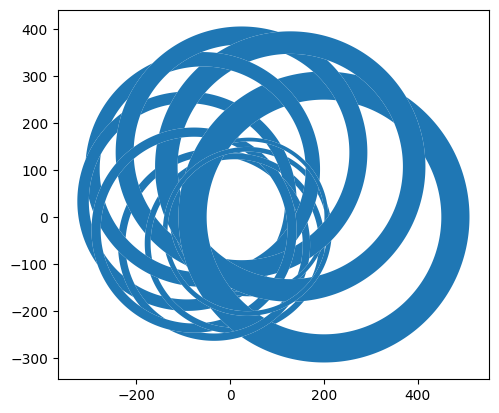

In [355]:

ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-6)
idx = idx & ~ngdf.is_empty
idx = idx & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf[idx].plot()

In [356]:

ngdf = ngdf[idx]

lss = [p.boundary for p in ngdf.geometry if p.boundary is not None]
mls = merge_LineStrings(lss)



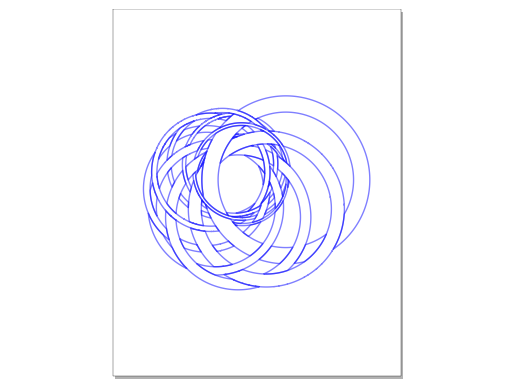

In [357]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(mls, drawbox))
sk.display()


In [362]:
sk.vpype('linesort')
fp = new_savepath(postfix='tangled_circles_no_fill')
sk.save(fp)

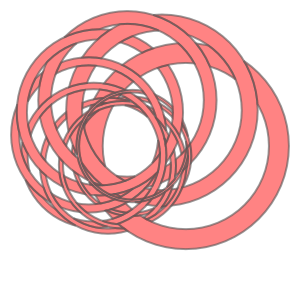

In [320]:
final_polys = make_like(MultiPolygon(ngdf.geometry.to_list()), drawbox)

In [345]:

fills = []
for p in final_polys.geoms:
    prms = MultiBufferTranslatePrms(
        n_iters=300,
        d_buffer = -0.4,
        d_translate_factor = 0.9, 
        angles=np.interp(p.centroid.x, [0, 210], [0, np.pi]),
        ).prms
    polys = multi_buffer_translate(p, **prms)
    fill = [p.boundary for p in polys]
    fills.extend(fill)


In [346]:
fills = [f for f in fills if f is not None]

In [347]:
mls = merge_LineStrings(fills)

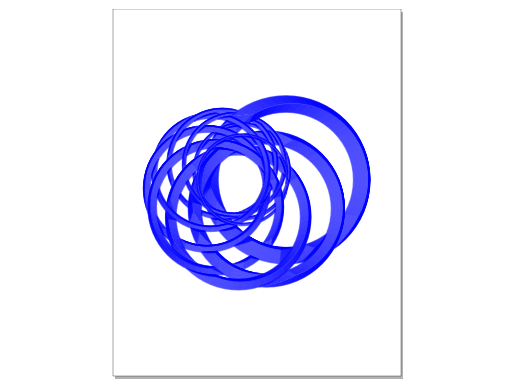

In [348]:

final_mls = make_like(mls, drawbox)
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)

sk.geometry(final_mls)
sk.display()

In [349]:
sk.vpype('splitall linemerge linesort')
fp = new_savepath(postfix='tangled_circles')
sk.save(fp)